# 项目历史轨迹分析

In [1]:
var openDigger = require("../src/open_digger")

//config variables
var repoId = 18044526;
var startYear = 2015;
var archiveYear = 2021;
var archiveMonth = 7;
var years = Array.from({ length: archiveYear - startYear + 1}, (_, i) => i + startYear); //[2015, 2016, 2017, 2018， 2019， 2020， 2021]


## 1. 每月新增 Star 和 Frok 的个数

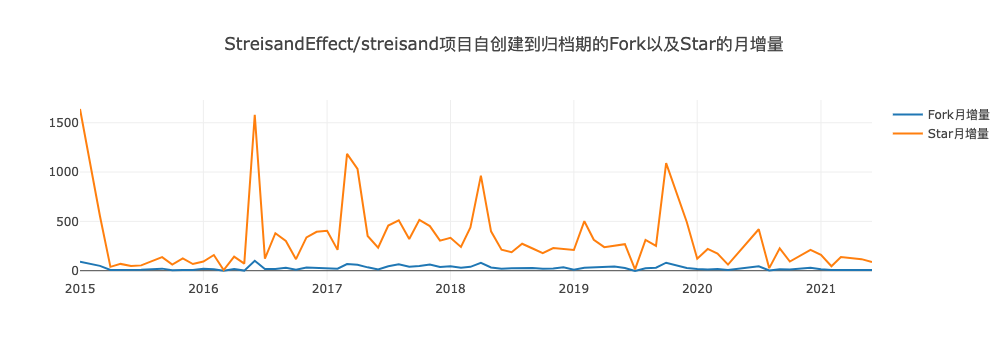

┌─────────┬───────────┬────────────┬────────────┐
│ (index) │   日期    │ Fork月增量 │ Star月增量 │
├─────────┼───────────┼────────────┼────────────┤
│    0    │ '2015-01' │     90     │    1639    │
│    1    │ '2015-03' │     49     │    554     │
│    2    │ '2015-04' │     7      │     39     │
│    3    │ '2015-05' │     8      │     69     │
│    4    │ '2015-06' │     5      │     48     │
│    5    │ '2015-07' │     9      │     54     │
│    6    │ '2015-09' │     21     │    137     │
│    7    │ '2015-10' │     5      │     63     │
│    8    │ '2015-11' │     8      │    125     │
│    9    │ '2015-12' │     8      │     68     │
│   10    │ '2016-01' │     19     │     93     │
│   11    │ '2016-02' │     15     │    159     │
│   12    │ '2016-03' │     -1     │     7      │
│   13    │ '2016-04' │     17     │    143     │
│   14    │ '2016-05' │     1      │     72     │
│   15    │ '2016-06' │    100     │    1581    │
│   16    │ '2016-07' │     18     │    122     │
│   17  

In [22]:
Promise.all(years.map(y => {
    var q = 
    `select toYear(created_date) as year, toMonth(created_date) as month, repo_forks_count, repo_stargazers_count
     from github_log.year${y}
     where id in
        (select max(id)
         from
            (select id, repo_forks_count, repo_stargazers_count, toMonth(created_date) as created_month
             from github_log.year${y}
             where repo_id=${repoId}
                and type in ('PullRequestEvent','PullRequestReviewCommentEvent'))month_log
         group by (created_month))
    order by(created_date)`
    return openDigger.driver.clickhouse.query(q);
})).then(data => {
    var year = [], month = [], repoForkNum = [], repoStarNum = [], repoForkInc = [], repoStarInc = [];
    
    data.forEach(d => {
        year = year.concat(d.map(t => t.year));
        month = month.concat(d.map(t => t.month));
        repoForkNum = repoForkNum.concat(d.map(t => t.repo_forks_count));
        repoStarNum = repoStarNum.concat(d.map(t => t.repo_stargazers_count));
    })

    var xAxis = [];
    var tableList = [];

    for(var i=0; i<year.length; i++){
        xAxis.push(year[i]+'-'+month[i].toString().padStart(2, '0'));
        if(i) {
            repoForkInc.push(repoForkNum[i] - repoForkNum[i-1]);
            repoStarInc.push(repoStarNum[i] - repoStarNum[i-1]);        
        } else {
            repoForkInc.push(repoForkNum[i]);
            repoStarInc.push(repoStarNum[i]);        
        }
        tableList.push([xAxis[i], repoForkInc[i], repoStarInc[i]])

    }
    openDigger.render.plotly([
        {x: xAxis, y: repoForkInc, mode: 'scatter', name: 'Fork月增量'},
        {x: xAxis, y: repoStarInc, mode: 'scatter', name: 'Star月增量'}
    ], {
        title: 'StreisandEffect/streisand项目自创建到归档期的Fork以及Star的月增量',
        xais: {type: 'category'}
    });
    console.table(tableList.map((l, i) => {
        return {
            '日期': l[0],
            'Fork月增量': l[1],
            'Star月增量': l[2]
        };
    
    }));
});

## 2. 每月打开 Issue 和 关闭 Issue 的个数

### 2.1 每月打开Issue的个数

┌─────────┬───────────┬──────┐
│ (index) │     0     │  1   │
├─────────┼───────────┼──────┤
│    0    │ '2015-01' │ '16' │
│    1    │ '2015-02' │ '9'  │
│    2    │ '2015-03' │ '16' │
│    3    │ '2015-04' │ '8'  │
│    4    │ '2015-05' │ '9'  │
│    5    │ '2015-06' │ '8'  │
│    6    │ '2015-07' │ '11' │
│    7    │ '2015-08' │ '4'  │
│    8    │ '2015-09' │ '4'  │
│    9    │ '2015-10' │ '5'  │
│   10    │ '2015-11' │ '13' │
│   11    │ '2015-12' │ '10' │
│   12    │ '2016-01' │ '13' │
│   13    │ '2016-02' │ '33' │
│   14    │ '2016-03' │ '11' │
│   15    │ '2016-04' │ '15' │
│   16    │ '2016-05' │ '8'  │
│   17    │ '2016-06' │ '54' │
│   18    │ '2016-07' │ '11' │
│   19    │ '2016-08' │ '25' │
│   20    │ '2016-09' │ '24' │
│   21    │ '2016-10' │ '18' │
│   22    │ '2016-11' │ '11' │
│   23    │ '2016-12' │ '20' │
│   24    │ '2017-01' │ '29' │
│   25    │ '2017-02' │ '34' │
│   26    │ '2017-03' │ '34' │
│   27    │ '2017-04' │ '99' │
│   28    │ '2017-05' │ '54' │
│   29  

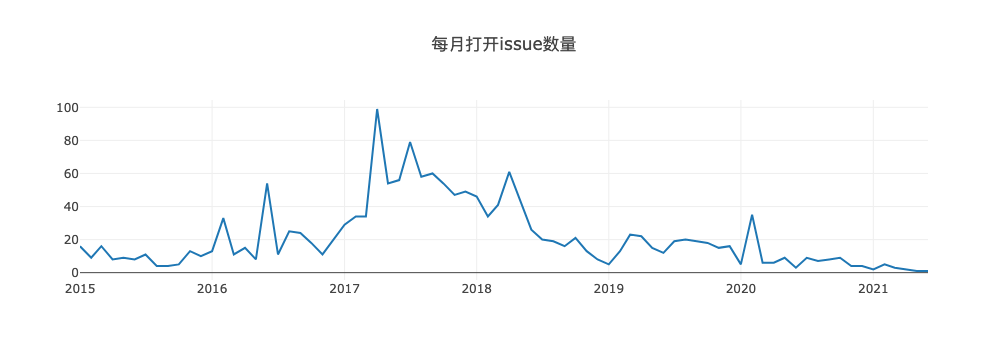

In [4]:
Promise.all(years.map(y=>{
    var q=`select issue_create_year, issue_create_month, count(issue_number) as create_issue_number
    from
    (select toYear(issue_created_at) as issue_create_year, toMonth(issue_created_at)as issue_create_month,issue_number
    from github_log.year${y}
         where repo_id='18044526'
               and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewComment')
                and action = 'opened'
    )t
    group by (issue_create_year, issue_create_month)
    order by (issue_create_year, issue_create_month)`;
    return openDigger.driver.clickhouse.query(q);
})).then(data =>
        {var createIssueCount = [], ytos = [],issuetable =[];
        data.forEach(d=> {
        d.forEach(t => {
            createIssueCount.push(t.create_issue_number);
            ytos.push(t.issue_create_year + '-' + t.issue_create_month.toString().padStart(2, '0'));
            issuetable.push([t.issue_create_year + '-' + t.issue_create_month.toString().padStart(2, '0'),t.create_issue_number])
    });
        });
         console.table(issuetable);
        openDigger.render.plotly([
        {x: ytos, y: createIssueCount, mode: 'scatter', name: '每月打开issue数量'},
    ], {
        title: '每月打开issue数量'
        ,yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' }
    });
});

### 2.2每月关闭Issue的个数

┌─────────┬───────────┬───────┐
│ (index) │     0     │   1   │
├─────────┼───────────┼───────┤
│    0    │ '2015-01' │ '13'  │
│    1    │ '2015-02' │ '10'  │
│    2    │ '2015-03' │  '6'  │
│    3    │ '2015-04' │  '9'  │
│    4    │ '2015-05' │  '9'  │
│    5    │ '2015-06' │  '7'  │
│    6    │ '2015-07' │  '3'  │
│    7    │ '2015-09' │ '14'  │
│    8    │ '2015-10' │  '4'  │
│    9    │ '2015-11' │ '16'  │
│   10    │ '2015-12' │  '2'  │
│   11    │ '2016-01' │ '18'  │
│   12    │ '2016-02' │ '28'  │
│   13    │ '2016-03' │ '12'  │
│   14    │ '2016-04' │ '14'  │
│   15    │ '2016-05' │  '4'  │
│   16    │ '2016-06' │ '30'  │
│   17    │ '2016-07' │ '13'  │
│   18    │ '2016-08' │ '24'  │
│   19    │ '2016-09' │  '4'  │
│   20    │ '2016-10' │ '17'  │
│   21    │ '2016-11' │  '5'  │
│   22    │ '2016-12' │ '11'  │
│   23    │ '2017-01' │ '15'  │
│   24    │ '2017-02' │ '24'  │
│   25    │ '2017-03' │  '8'  │
│   26    │ '2017-04' │ '118' │
│   27    │ '2017-05' │ '72'  │
│   28  

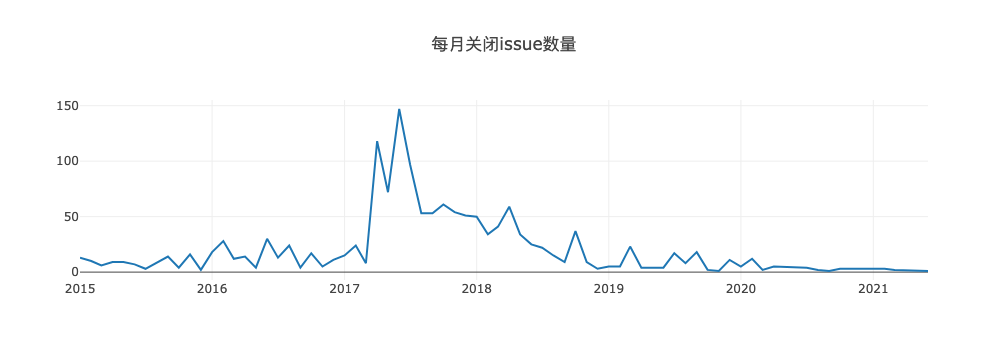

In [7]:
Promise.all(years.map(y=>{
    var q=`select issue_close_year, issue_close_month, count(issue_number) as close_issue_number
    from
    (select toYear(issue_closed_at) as issue_close_year, toMonth(issue_closed_at)as issue_close_month,issue_number
    from github_log.year${y}
         where repo_id='18044526'
               and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewComment')
                and action = 'closed'
    )t
    group by (issue_close_year, issue_close_month)
    order by (issue_close_year, issue_close_month)`;
    return openDigger.driver.clickhouse.query(q);
})).then(data =>
        {var closeIssueCount = [], ytos = [],issuetable=[];
        data.forEach(d=> {
        d.forEach(t => {
            closeIssueCount.push(t.close_issue_number);
            ytos.push(t.issue_close_year + '-' + t.issue_close_month.toString().padStart(2, '0'));
            issuetable.push([t.issue_close_year + '-' + t.issue_close_month.toString().padStart(2, '0'),t.close_issue_number])
    });
        });
         console.table(issuetable);
        openDigger.render.plotly([
        {x: ytos, y: closeIssueCount, mode: 'scatter', name: '每月关闭issue数量'},
    ], {
        title: '每月关闭issue数量',
        yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' }
    });
});

## 3. 每月打开 PR 和合入 PR 的个数（注意，关闭 PR 不等于合入）

### 3.1每月打开PR的个数

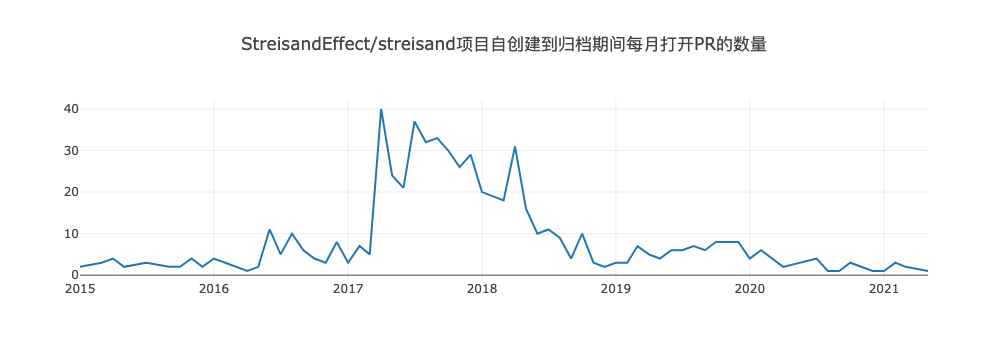

┌─────────┬───────────┬────────────┐
│ (index) │   日期    │ PR打开月量 │
├─────────┼───────────┼────────────┤
│    0    │ '2015-01' │    '2'     │
│    1    │ '2015-03' │    '3'     │
│    2    │ '2015-04' │    '4'     │
│    3    │ '2015-05' │    '2'     │
│    4    │ '2015-07' │    '3'     │
│    5    │ '2015-09' │    '2'     │
│    6    │ '2015-10' │    '2'     │
│    7    │ '2015-11' │    '4'     │
│    8    │ '2015-12' │    '2'     │
│    9    │ '2016-01' │    '4'     │
│   10    │ '2016-02' │    '3'     │
│   11    │ '2016-04' │    '1'     │
│   12    │ '2016-05' │    '2'     │
│   13    │ '2016-06' │    '11'    │
│   14    │ '2016-07' │    '5'     │
│   15    │ '2016-08' │    '10'    │
│   16    │ '2016-09' │    '6'     │
│   17    │ '2016-10' │    '4'     │
│   18    │ '2016-11' │    '3'     │
│   19    │ '2016-12' │    '8'     │
│   20    │ '2017-01' │    '3'     │
│   21    │ '2017-02' │    '7'     │
│   22    │ '2017-03' │    '5'     │
│   23    │ '2017-04' │    '40'    │
│   24 

In [25]:
//每月打开PR的个数
Promise.all(years.map(y => {
    var q = 
    `select year, month, count(issue_id) AS PRCreateCount
    from
    (
        select toYear(issue_created_at) AS year, toMonth(issue_created_at) AS month, issue_id  
        from github_log.year${y}
        where repo_id = ${repoId}
        and type = 'PullRequestEvent'
        and action = 'opened'
        and toYear(issue_created_at) = ${y}
    )t1
    group by (year, month)
    order by (year, month)`
    return openDigger.driver.clickhouse.query(q);
})).then(data=> {
    var year = [], month = [], PRCreateCount = [];
    
    data.forEach(d => {
        year = year.concat(d.map(t => t.year));
        month = month.concat(d.map(t => t.month));
        PRCreateCount = PRCreateCount.concat(d.map(t => t.PRCreateCount));
    });

    var xAxis = [];
    var tableList = [];
    for(var i=0; i<year.length; i++){
        xAxis.push(year[i]+'-'+month[i].toString().padStart(2, '0'));
        tableList.push([xAxis[i], PRCreateCount[i]])
    }
    openDigger.render.plotly([
        {x: xAxis, y: PRCreateCount, mode: 'scatter', name: 'PR打开月数量'}
    ], {
        title: 'StreisandEffect/streisand项目自创建到归档期间每月打开PR的数量',
        xais: {type: 'category'}
    });
    console.table(tableList.map((l, i) => {
        return {
            '日期': l[0],
            'PR打开月量': l[1]
        }
    }));
});

### 3.2 每月合入PR的个数

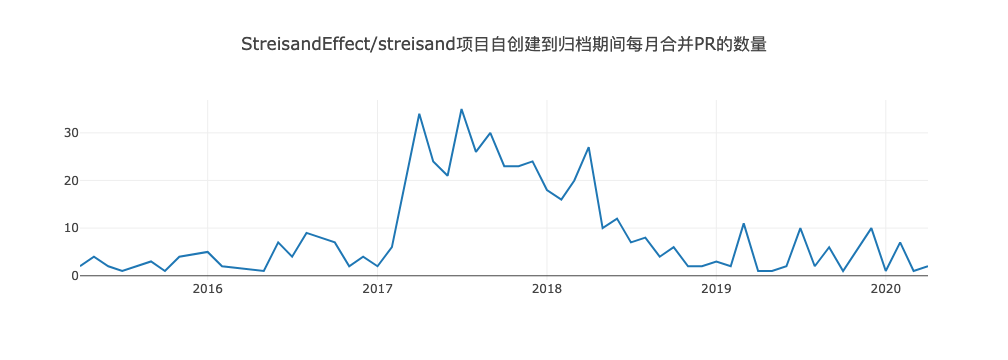

┌─────────┬───────────┬────────────┐
│ (index) │   日期    │ PR合入月量 │
├─────────┼───────────┼────────────┤
│    0    │ '2015-04' │    '2'     │
│    1    │ '2015-05' │    '4'     │
│    2    │ '2015-06' │    '2'     │
│    3    │ '2015-07' │    '1'     │
│    4    │ '2015-09' │    '3'     │
│    5    │ '2015-10' │    '1'     │
│    6    │ '2015-11' │    '4'     │
│    7    │ '2016-01' │    '5'     │
│    8    │ '2016-02' │    '2'     │
│    9    │ '2016-05' │    '1'     │
│   10    │ '2016-06' │    '7'     │
│   11    │ '2016-07' │    '4'     │
│   12    │ '2016-08' │    '9'     │
│   13    │ '2016-10' │    '7'     │
│   14    │ '2016-11' │    '2'     │
│   15    │ '2016-12' │    '4'     │
│   16    │ '2017-01' │    '2'     │
│   17    │ '2017-02' │    '6'     │
│   18    │ '2017-04' │    '34'    │
│   19    │ '2017-05' │    '24'    │
│   20    │ '2017-06' │    '21'    │
│   21    │ '2017-07' │    '35'    │
│   22    │ '2017-08' │    '26'    │
│   23    │ '2017-09' │    '30'    │
│   24 

In [27]:


//每月合入PR的个数
Promise.all(years.map(y => {
    var q = 
    `select year, month, count(issue_id) AS PRMergeCount
    from 
    (
        select toYear(pull_merged_at) AS year, toMonth(pull_merged_at) AS month, issue_id
        from github_log.year${y}
        where repo_id = ${repoId}
            and type = 'PullRequestEvent'
            and pull_merged = 1
            and toYear(pull_merged_at) = ${y}
    )t1
    group by (year, month)
    order by (year, month)`
    return openDigger.driver.clickhouse.query(q);
})).then(data=> {
    var year = [], month = [], PRMergeCount = [];
    
    data.forEach(d => {
        year = year.concat(d.map(t => t.year));
        month = month.concat(d.map(t => t.month));
        PRMergeCount = PRMergeCount.concat(d.map(t => t.PRMergeCount));
    });

    var xAxis = [];
    var tableList = [];
    for(var i=0; i<year.length; i++){
        xAxis.push(year[i]+'-'+month[i].toString().padStart(2, '0'));
        tableList.push([xAxis[i], PRMergeCount[i]])
    }
    openDigger.render.plotly([
        {x: xAxis, y: PRMergeCount, mode: 'scatter', name: 'PR合并月数量'}
    ], {
        title: 'StreisandEffect/streisand项目自创建到归档期间每月合并PR的数量',
        xais: {type: 'category'}
    });
    console.table(tableList.map((l, i) => {
        return {
            '日期': l[0],
            'PR合入月量': l[1]
        }
    }));
})

## 4. 每月在仓库中活跃（只要有日志产生就算）的不同开发者总数

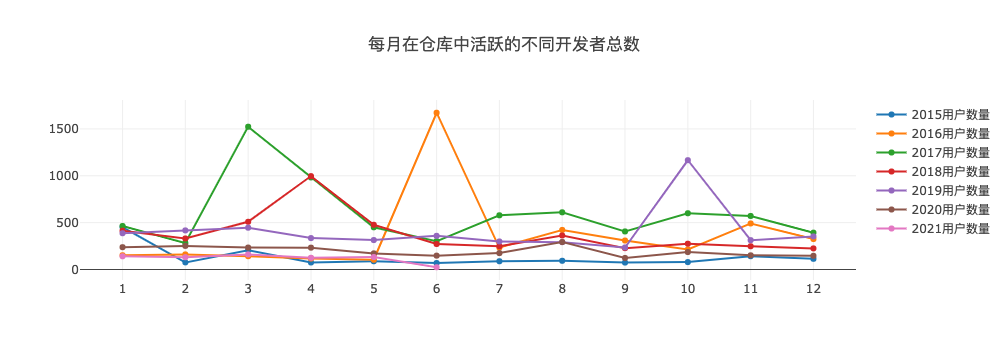

In [11]:
//计算各年的不同月份用户活跃情况
var start_year=2015,end_year=2022;
var years = Array.from({ length: end_year - start_year + 1 }, (_, i) => i + start_year);

Promise.all(
    years.map(y => { 
       var q=
           `select count(distinct actor_id) AS actor_id_count,toMonth(created_date) AS month
            from github_log.year${y} 
            where repo_id='18044526'
            and toString(created_date)<='2021-06-04'
            group by month
            order by month`;
        return openDigger.driver.clickhouse.query(q);
    })
).then(data=>{
    var activeActor2015=[],xmonth2015 =[],activeActor2016=[],xmonth2016 =[];
    var activeActor2017=[],xmonth2017 =[],activeActor2018=[],xmonth2018 =[];
    var activeActor2019=[],xmonth2019 =[],activeActor2020=[],xmonth2020 =[];
    var activeActor2021=[],xmonth2021 =[],activeActor2022=[],xmonth2022 =[];    
 
    data[0].forEach(item=>{xmonth2015.push(item.month);activeActor2015.push(item.actor_id_count);});
    data[1].forEach(item=>{xmonth2016.push(item.month);activeActor2016.push(item.actor_id_count);});
    data[2].forEach(item=>{xmonth2017.push(item.month);activeActor2017.push(item.actor_id_count);});
    data[3].forEach(item=>{xmonth2018.push(item.month);activeActor2018.push(item.actor_id_count);});
    data[4].forEach(item=>{xmonth2019.push(item.month);activeActor2019.push(item.actor_id_count);});
    data[5].forEach(item=>{xmonth2020.push(item.month);activeActor2020.push(item.actor_id_count);});
    data[6].forEach(item=>{xmonth2021.push(item.month);activeActor2021.push(item.actor_id_count);});
    data[7].forEach(item=>{xmonth2022.push(item.month);activeActor2022.push(item.actor_id_count);});
      
    openDigger.render.plotly([
        {x: xmonth2015, y: activeActor2015, mode: 'scatter', name: '2015用户数量'},
        {x: xmonth2016, y: activeActor2016, mode: 'scatter', name: '2016用户数量'},
        {x: xmonth2017, y: activeActor2017, mode: 'scatter', name: '2017用户数量'},
        {x: xmonth2018, y: activeActor2018, mode: 'scatter', name: '2018用户数量'},
        {x: xmonth2019, y: activeActor2019, mode: 'scatter', name: '2019用户数量'},
        {x: xmonth2020, y: activeActor2020, mode: 'scatter', name: '2020用户数量'},
        {x: xmonth2021, y: activeActor2021, mode: 'scatter', name: '2021用户数量'},
        {x: xmonth2022, y: activeActor2022, mode: 'scatter', name: '2022用户数量'}],
                             { 
        title: '每月在仓库中活跃的不同开发者总数',
        xaxis: {type: 'category'}}
    );
});

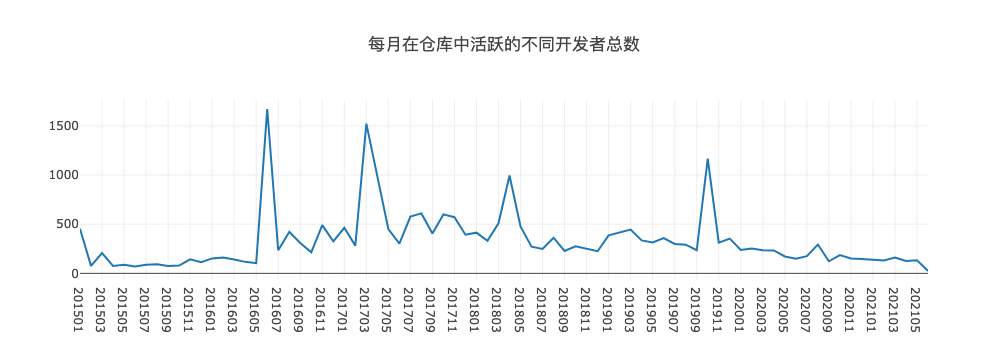

┌─────────┬────────┬────────────────────────────────┐
│ (index) │  月份  │ 该月仓库中活跃的不同开发者总数 │
├─────────┼────────┼────────────────────────────────┤
│    0    │ 201501 │             '453'              │
│    1    │ 201502 │              '76'              │
│    2    │ 201503 │             '206'              │
│    3    │ 201504 │              '75'              │
│    4    │ 201505 │              '88'              │
│    5    │ 201506 │              '69'              │
│    6    │ 201507 │              '88'              │
│    7    │ 201508 │              '93'              │
│    8    │ 201509 │              '74'              │
│    9    │ 201510 │              '79'              │
│   10    │ 201511 │             '142'              │
│   11    │ 201512 │             '114'              │
│   12    │ 201601 │             '152'              │
│   13    │ 201602 │             '161'              │
│   14    │ 201603 │             '142'              │
│   15    │ 201604 │             '117'       

In [10]:
// 4-计算在项目2015-归档期间各月用户活跃情况 -绘制了折线图和表格
Promise.all(
    years.map(y => { 
       var q=
           `select count(distinct actor_id) AS active_actor_count,toYYYYMM(created_date) AS month
            from github_log.year${y} 
            where repo_id='18044526'
            and toString(created_date)<='2021-06-04'
            group by month
            order by month`;
        return openDigger.driver.clickhouse.query(q);
    })
).then(data=>{
    var activeActor=[],xmonth =[],list=[];
    data.forEach(d => {
        d.forEach(item=>{
            list.push(item);
            xmonth.push(item.month);
            activeActor.push(item.active_actor_count);
        })
    });   
    openDigger.render.plotly([
        {x: xmonth, y: activeActor, mode: 'scatter', name: '用户数量'}],
                             { 
        title: '每月在仓库中活跃的不同开发者总数',
        xaxis: {type: 'category'}}
    );
        console.table(list.map((p, i) => {
        
        return {
            '月份': p.month,
            '该月仓库中活跃的不同开发者总数': p.active_actor_count
             };
    }));
});

## 5. Issue 从打开到关闭的平均时长和中位数（单位：天）

In [9]:
openDigger.driver.clickhouse.query(
    `select avg(issue_days) as issue_avg,median(issue_days) as issue_mid
    from(
    select toRelativeDayNum(issue_closed_at)-toRelativeDayNum(issue_created_at) as issue_days from github_log.year2015 where repo_id='18044526' AND type='IssuesEvent' AND issue_days>=0
    UNION ALL
    select toRelativeDayNum(issue_closed_at)-toRelativeDayNum(issue_created_at) as issue_days from github_log.year2016 where repo_id='18044526' AND type='IssuesEvent' AND issue_days>=0
    UNION ALL
    select toRelativeDayNum(issue_closed_at)-toRelativeDayNum(issue_created_at) as issue_days from github_log.year2017 where repo_id='18044526' AND type='IssuesEvent' AND issue_days>=0
    UNION ALL
    select toRelativeDayNum(issue_closed_at)-toRelativeDayNum(issue_created_at) as issue_days from github_log.year2018 where repo_id='18044526' AND type='IssuesEvent' AND issue_days>=0
    UNION ALL
    select toRelativeDayNum(issue_closed_at)-toRelativeDayNum(issue_created_at) as issue_days from github_log.year2019 where repo_id='18044526' AND type='IssuesEvent' AND issue_days>=0
    UNION ALL
    select toRelativeDayNum(issue_closed_at)-toRelativeDayNum(issue_created_at) as issue_days from github_log.year2020 where repo_id='18044526' AND type='IssuesEvent' AND issue_days>=0
    UNION ALL
    select toRelativeDayNum(issue_closed_at)-toRelativeDayNum(issue_created_at) as issue_days from github_log.year2021 where repo_id='18044526' AND type='IssuesEvent' AND issue_days>=0
    )`
).then(res=>{    console.log(res);});

[ { issue_avg: 96.37252747252747, issue_mid: 7 } ]


## 6. PR 从打开到合入的平均时长和中位数（单位：天）

In [12]:
//6-PR 从打开到合入的平均时长和中位数（单位：天）
Promise.all(
    years.map(y => { 
       var q=
           `select issue_number,dateDiff('day',issue_created_at,pull_merged_at) AS length
                from github_log.year${y} 
                where repo_id='18044526' 
                and type='PullRequestEvent'
                and pull_merged = 1                
            `;
        return openDigger.driver.clickhouse.query(q);
    })
).then(data=>{
    var list=[];
    data.forEach(d=>{
        d.forEach(item=>{
            list.push(Number(item.length))
        })
    });
    
    list.sort();
    var mid_value,mid_index,sum,average;
    mid_index=list.length/2;
    sum=0;
    if(list.length%2==0){         
        mid_value=(list[mid_index]+list[mid_index+1])/2;
    }else{
        mid_value=list[mid_index+1];
    }
    for(var i=0;i<list.length;i++){
        sum+=list[i];
    }
    average=sum/list.length;
    //console.log(list);
    //console.log('sum'+sum);
    console.log('average:'+average);
    console.log('mid_value:'+mid_value);
});

average:10.441767068273093
mid_value:1


## 7. Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

### 7.1 Issue 从打开到第一次有人回复（非本人回复）的平均时长和中位数

average:20.493638676844785
mid_value:1


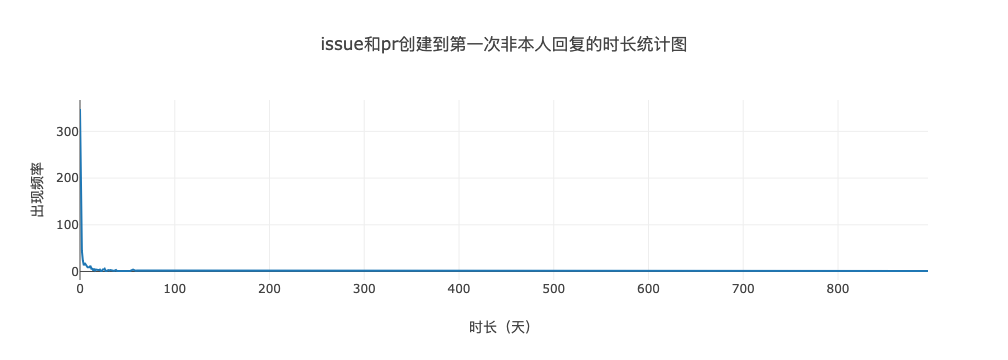

In [13]:
//7-issue正确的
var issue_number_list = [], issue_length_list=[]; 
Promise.all(
    years.map(y => { 
       var q=
           `select issue_number,min(dateDiff('day',issue_created_at,issue_comment_created_at)) AS length      
           from github_log.year${y} t
                where t.repo_id='18044526' 
                and t.type in ('IssueCommentEvent')
                and t.issue_author_id <> t.issue_comment_author_id
                and t.issue_number in (
                        select issue_number from github_log.year2015 where repo_id='18044526' and type = 'IssueCommentEvent' and issue_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2016 where repo_id='18044526' and type = 'IssueCommentEvent' and issue_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2017 where repo_id='18044526' and type = 'IssueCommentEvent' and issue_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2018 where repo_id='18044526' and type = 'IssueCommentEvent' and issue_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2019 where repo_id='18044526' and type = 'IssueCommentEvent' and issue_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2020 where repo_id='18044526' and type = 'IssueCommentEvent' and issue_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2021 where repo_id='18044526' and type = 'IssueCommentEvent' and issue_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2022 where repo_id='18044526' and type = 'IssueCommentEvent' and issue_comments = '0'
                        )
                group by t.issue_number
            `;
        return openDigger.driver.clickhouse.query(q);
    })
).then(data=>{
    var count=0;
    data.forEach(d=>{
        d.forEach(item=>{
            if(item.length!='0')
            {
                //console.log(item);
                count++;
            }
        var flag=0;
        for(var i=0;i<issue_number_list.length;i++)
        {
            if(issue_number_list[i]==item.issue_number)
            {
                  flag=1;
            }    
        }
        if(flag==0)
        {
            issue_number_list.push(item.issue_number);
            issue_length_list.push(Number(item.length));
        }
        });  
    });
    
    issue_length_list.sort(function(a,b){return a-b;});
    //console.log(length_list);
    var mid_value,mid_index,sum,average;
    mid_index=issue_length_list.length/2;
    sum=0;
    if(issue_length_list.length%2==0){         
        mid_value=(issue_length_list[mid_index]+issue_length_list[mid_index+1])/2;
    }else{
        mid_index-=0.5;
        mid_value=issue_length_list[mid_index];
    }
    for(var i=0;i<issue_length_list.length;i++){
          sum+=issue_length_list[i];
    }
    average=sum/issue_length_list.length;
    //console.log("sum"+sum);
    console.log('average:'+average);
    console.log('mid_value:'+mid_value);
    // console.log("count非0："+count);
    // console.log("count all:"+issue_length_list.length);
    
        var issue_current_value=issue_length_list[0];
    var x_issue_length_value=[],y_issue_count=[],issue_index=0;
    x_issue_length_value.push(issue_current_value);
    y_issue_count.push(Number(1));
    for(var i=1;i<issue_length_list.length;i++)
    {
        if(issue_length_list[i]==issue_current_value){
            y_issue_count[issue_index]++;
        }else{
            issue_current_value=issue_length_list[i];
            x_issue_length_value.push(issue_length_list[i]);
            y_issue_count.push(Number(1));            
            issue_index++;
        }            
    }
    
    openDigger.render.plotly([
        {x: x_issue_length_value, y: y_issue_count, mode: 'scatter', name: 'issue创建到第一次非本人回复'},
],
                             { 
        title: 'issue和pr创建到第一次非本人回复的时长统计图',
        xaxis: {title: '时长（天）'},
        yaxis: {title:'出现频率'}
    }
        
    );
    
});

### 总体呈长尾分布，说明跨年数据比较多，平均值不能代表总体水平，所以如下分析Issue创建和第一次评论不跨年的情况，可见此时平均数和中位数水平相当

In [16]:

Promise.all(years.map(y => {
    var q = 
    `select avg(dateDiff('day', create_time, comment_time))As average, quantile(dateDiff('day', create_time, comment_time)) AS median
    from
        (select issue_id, issue_created_at AS create_time
        from github_log.year${y}
        where repo_id = ${repoId}
        and type = 'IssuesEvent'
        and action = 'opened'
        and toYear(issue_created_at) = ${y})t1, 
    (select issue_id, min(issue_comment_created_at) AS comment_time
        from github_log.year${y}
        where repo_id = ${repoId}
        and type = 'IssueCommentEvent'
        and issue_comment_author_id <> issue_author_id
        group by issue_id)t2
    where t1.issue_id = t2.issue_id
`;
    return openDigger.driver.clickhouse.query(q);
})).then(data => {console.log(data)});


[
  [ { average: 10.053333333333333, median: 1 } ],
  [ { average: 5.780821917808219, median: 1 } ],
  [ { average: 9.236666666666666, median: 0 } ],
  [ { average: 4.886075949367089, median: 1 } ],
  [ { average: 10.773333333333333, median: 3 } ],
  [ { average: 11.333333333333334, median: 8 } ],
  [ { average: 3, median: 3 } ],
  [ { average: null, median: null } ]
]


### 7.2 PR 从打开到第一次有人回复（非本人回复）的平均时长和中位数

average:7.5210084033613445
mid_value:2


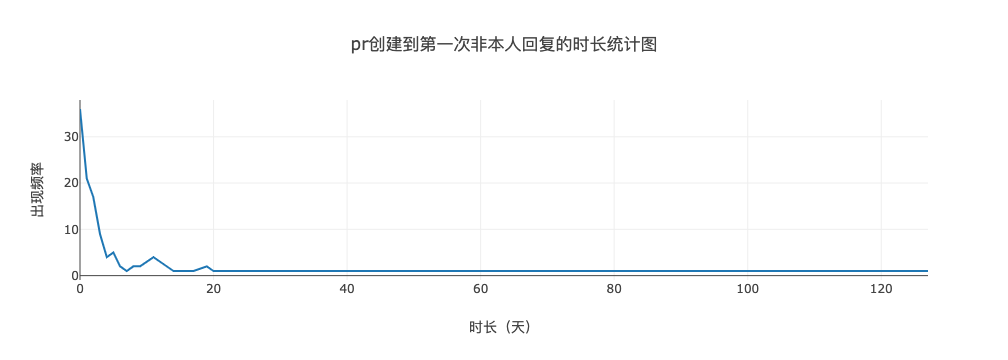

In [31]:
//7-pr-正确的
Promise.all(
    years.map(y => { 
       var q=
           `select issue_number,min(dateDiff('day',issue_created_at,pull_review_comment_created_at))  AS length    
           from github_log.year${y} 
                where repo_id='18044526' 
                and type in ('PullRequestReviewCommentEvent')
                and pull_review_comment_author_id <> issue_author_id
                and issue_number in (
                        select issue_number from github_log.year2015 where repo_id='18044526' and type = 'PullRequestReviewCommentEvent' and pull_review_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2016 where repo_id='18044526' and type = 'PullRequestReviewCommentEvent' and pull_review_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2017 where repo_id='18044526' and type = 'PullRequestReviewCommentEvent' and pull_review_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2018 where repo_id='18044526' and type = 'PullRequestReviewCommentEvent' and pull_review_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2019 where repo_id='18044526' and type = 'PullRequestReviewCommentEvent' and pull_review_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2020 where repo_id='18044526' and type = 'PullRequestReviewCommentEvent' and pull_review_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2021 where repo_id='18044526' and type = 'PullRequestReviewCommentEvent' and pull_review_comments = '0'
                        UNION ALL
                        select issue_number from github_log.year2022 where repo_id='18044526' and type = 'PullRequestReviewCommentEvent' and pull_review_comments = '0'
                )
                group by issue_number
            `;
        return openDigger.driver.clickhouse.query(q);
    })
).then(data=>{
    var number_list = [],  pr_list_length=[]; 
    var count=0;
    data.forEach(d=>{
        d.forEach(item=>{
            if(item.length!=0)
            {
                //console.log(item);
                count++;
            }
        var flag=0;
        for(var i=0;i<number_list.length;i++)
        {
            if(number_list[i]==item.issue_number)
            {
                  flag=1;
            }    
        }
        if(flag==0)
        {
            number_list.push(item.issue_number);
            pr_list_length.push(Number(item.length));
        }
        });  
    });
    
    //console.log(length_list);
     pr_list_length.sort(function(a,b){return a-b;});
    //console.log(length_list);
    
    var mid_value,mid_index,sum,average;
    mid_index= pr_list_length.length/2;
    sum=0;
    if( pr_list_length.length%2==0){
        mid_value=( pr_list_length[mid_index]+ pr_list_length[mid_index+1])/2;
    }else{        
        mid_index-=0.5;
        mid_value= pr_list_length[mid_index+1];
    }
    for(var i=0;i< pr_list_length.length;i++){
          sum+= pr_list_length[i];
    }
    average=sum/ pr_list_length.length;
    //console.log("sum"+sum);
    console.log('average:'+average);
    console.log('mid_value:'+mid_value);
    // console.log("count非0："+count);
    // console.log("count all:"+length_list.length);
    
    //pr_list_length.sort(function(a,b){return a-b;});
    
    var pr_current_value=pr_list_length[0];
    var x_pr_length_value=[],y_pr_count=[],pr_index=0;
    x_pr_length_value.push(pr_current_value);
    y_pr_count.push(Number(1));
    for(var i=1;i<pr_list_length.length;i++)
    {
        if(pr_list_length[i]==pr_current_value){
            y_pr_count[pr_index]++;
        }else{
            pr_current_value=pr_list_length[i];
            x_pr_length_value.push(pr_list_length[i]);
            y_pr_count.push(Number(1));            
            pr_index++;
        }            
    }


    openDigger.render.plotly([
        
        {x: x_pr_length_value, y: y_pr_count, mode: 'scatter', name: 'pr创建到第一次非本人回复'}],
                             { 
        title: 'pr创建到第一次非本人回复的时长统计图',
        xaxis: {title: '时长（天）'},
        yaxis: {title:'出现频率'}
    }   
    );
    
});

### 总体呈长尾分布，说明跨年数据比较多，平均值不能代表总体水平，所以如下分析PR创建和第一次评论不跨年的情况，此时平均数和中位数水平相当
从恢复时间来看，16，17，18年是PR活跃高峰期，19，20年之后活跃度逐年下降，但更确切的证据还需要从PR合入数量月分布分析

In [28]:

Promise.all(years.map(y => {
    var q = 
    `select avg(dateDiff('day', create_time, comment_time))As average, quantile(dateDiff('day', create_time, comment_time)) AS median
    from
        (select issue_id, issue_created_at AS create_time
        from github_log.year${y}
        where repo_id = ${repoId}
        and type = 'PullRequestEvent'
        and action = 'opened'
        and toYear(issue_created_at) = ${y})t1, 
        (select issue_id, min(pull_review_comment_created_at) AS comment_time
        from github_log.year${y}
        where repo_id = ${repoId}
        and type = 'PullRequestReviewCommentEvent'
        and issue_author_id <> pull_review_comment_author_id
        group by issue_id)t2
    where t1.issue_id = t2.issue_id
`;
    return openDigger.driver.clickhouse.query(q);
})).then(data => {console.log(data)});

[
  [ { average: 20.8, median: 11 } ],
  [ { average: 6, median: 5 } ],
  [ { average: 3.4027777777777777, median: 1 } ],
  [ { average: 7.62962962962963, median: 2 } ],
  [ { average: 38.857142857142854, median: 19 } ],
  [ { average: null, median: null } ],
  [ { average: null, median: null } ],
  [ { average: null, median: null } ]
]


## 8. 根据你观察到的仓库的历史数据，尝试找到几个你认为关键或值得注意的时间节点

该部分内容合入第三部分md文件中